![title](edel.JPG)

# Edelweiss Hackathon-Machine Learning

## Predict Price Movement

### Broad Objective

To predict short term (intraday) price movement of various stocks on the basis of its price and combination of multiple features provided.

### Data Provided:
We have provided historical 5-min tick data for a universe of more than 150 stocks. The data has the following features:

* **Mid_Price:** The price over which the returns need to be calculated
* **Date and Time**
* **46 anonymized features**

### Methodology

The algorithm will decide whether to take a position in a stock (buy/sell)
Returns calculated will be calculated as

* If there is no current position in any stocks  at any point;  the algorithm can either buy an stocks or sell an stocks ; If the stock is bought it’s called a long position, and if the stock is sold its called a short position

* If there is a long position, the algo can only square-off the position: It means it will sell the current long position and become position neutral.

* If there is a short position, the algo can only square-off the position: It means it will buy  the current short position and become position neutral.

* At 3:15 PM every day the algo mandatorily should square-off any open position.

* Return should be calculated only when the positions are square-off: If the position was long the return calculated will be equal to ((exit price- entryprice)/entryprice)

* If the position was short the return calculated will be equal to ((entryprice -exit price)/entryprice)

* For any new entry with exit the “number of trades” will be equal to 1; for example if one enters underlying4 at 1:00 PM and exits at 3:15 , number of the trade for that day for that particular stock will be 1.

* Since all the price prediction needs to be done intraday , all the positions can get opened after (9:30 AM) and should exit at or before (3:15 PM)

### Output:

It should have the following information

* Stocks wise daily return (daily return(a)):  Return for any day for any stock : sum of all trades return for that day: For example : for underlying 7 : the algo enters long at 1:20 PM and square-off the position at 2:40 PM: and again goes short 2:45 and square-off at 3:15. The return for that day will be the return of two trades taken that day.

* Stocks wise number of daily trades (trades(b)) : Trades for any day for any stock : sum of all trades for that day. For example: the trades will be equal to 2, as in the above mentioned example.

### Detailed Objective:
* You have predict the Mid-price on the testing data and then build an algorithm that predicts the Buy/Sell decisions (Long/ Short positions) for the predicted Mid-prices.

* The final optimisation problem would be to maximise  of ((a)-(0.12%)*(b)) *(b), this will be the criterion for selecting the price predicting algos

However, there must be a minimum of 20 trades per stocks; averaged across stock.

# Calculating Buy/Sell

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/edelwiess-submission-format"))


# Any results you write to the current directory are saved as output.
from tqdm import tqdm_notebook as tqdm

['submission_format923c8d6.csv', 'HE_Edel_pricelgbm_2.csv', 'HE_Edel_pricelgbm_1.csv']


## Importing data

In [2]:
TRAIN_PATH='../input/hackerearth-predict-price-movement-edlewiess/dataset/dataset/train/'
TEST_PATH='../input/hackerearth-predict-price-movement-edlewiess/dataset/dataset/test/'

train1=pd.read_csv(TRAIN_PATH+'train1.csv')
test1=pd.read_csv(TEST_PATH+'test1.csv')
for i in [2,3]:
    train1=train1.append(pd.read_csv(TRAIN_PATH+'train'+str(i)+'.csv'))
    test1=test1.append(pd.read_csv(TEST_PATH+'test'+str(i)+'.csv'))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Importing Predicted Stock prices and sample submission

In [3]:
p=pd.read_csv('../input/edelwiess-submission-format/HE_Edel_pricelgbm.csv')
p.head()
sub=pd.read_csv('../input/edelwiess-submission-format/submission_format923c8d6.csv')
p.head()

,UID,MidPrice
0,01-06-2015 09:20 und_109,1671.733879
1,01-06-2015 09:25 und_109,1661.793002
2,01-06-2015 09:30 und_109,1656.358891
3,01-06-2015 09:35 und_109,1665.767331
4,01-06-2015 09:40 und_109,1665.923826


** Building Train and Test Data **

In [4]:
train1=train1[['UID', 'Date', 'Time', 'Symbol','MidPrice']]

In [5]:
test1=test1[['UID', 'Date', 'Time', 'Symbol']]

In [6]:
test1.head()

,UID,Date,Time,Symbol
0,01-06-2015 09:20 und_109,01-06-2015,09:20,und_109
1,01-06-2015 09:25 und_109,01-06-2015,09:25,und_109
2,01-06-2015 09:30 und_109,01-06-2015,09:30,und_109
3,01-06-2015 09:35 und_109,01-06-2015,09:35,und_109
4,01-06-2015 09:40 und_109,01-06-2015,09:40,und_109


In [7]:
df=test1.merge(p,on='UID')

In [8]:
df=sub.drop('BuySell',axis=1).merge(df,on=['UID'],how='left')
df.head()

,UID,Date,Time,Symbol,MidPrice
0,01-06-2015 09:30 und_109,01-06-2015,09:30,und_109,1656.358891
1,01-06-2015 09:35 und_109,01-06-2015,09:35,und_109,1665.767331
2,01-06-2015 09:40 und_109,01-06-2015,09:40,und_109,1665.923826
3,01-06-2015 09:45 und_109,01-06-2015,09:45,und_109,1669.135710
4,01-06-2015 09:50 und_109,01-06-2015,09:50,und_109,1667.524831


# Evaluation Script

In [9]:

import csv
import json
import sys
import pandas as pd
import numpy as np
import gc
import time

def returns(entry, exit, position):
    """Calculates the returns for the given entry_pt and exit_pt"""
    return (-1) * position * (exit - entry) / entry

def eval_score(stock_prices):
    """
    a : daily returns
    b : number of trades
    """
    if len(stock_prices) == 0:
        return 0.0

    # daily returns for the given stock
    a = sum(stock_prices)
    # number of trades for the given stock
    b = len(stock_prices)
    print('sum',a,'trades',b)
    # check for min number of trades per stock
    # There are 160 unique stocks
    if (b/160) >= 20:
        score = (a - (b * 0.12 / 100)) * b
    else:
        score = 0.0

    return score

def daily_return_per_stock(stockdata):
    stock_prices = []
    entry_pt = 0
    exit_pt = 0
    exit_pt_set = False
    entry_pt_set = False
    prev_date = stockdata['Date'][0]
    prev_buy_sell = stockdata['BuySell'][0]
    for i in range(stockdata.shape[0]):
        # For same day calculate daily returns for the given stock
        if stockdata['Time'][i] >= '15:15' and stockdata['BuySell'][i] != 0:
            raise Exception('The BuySell decision should be squared off before 15:15 PM. Check UID : {}'.format(
                stockdata['UID'][i]))
        if (abs(stockdata['BuySell'][i] - prev_buy_sell) == 1):
            if entry_pt_set:
                exit_pt = stockdata['MidPrice'][i]
                # Calculating the position (long or short)
                position = stockdata['BuySell'][i] - prev_buy_sell
                print('position',position,'ENtry pointset: ',entry_pt_set,'ENP :',entry_pt,'EXP :', exit_pt)
                try:
                    r = returns(entry_pt, exit_pt, position)
                except:
                    r = 0
                stock_prices.append(r)
                entry_pt_set = False
            else:
                entry_pt = stockdata['MidPrice'][i]
                entry_pt_set = True
            
        prev_date = stockdata['Date'][i]
        prev_buy_sell = stockdata['BuySell'][i]
    return stock_prices

def filter_by_date_and_stock(stockdata, stock_name, date):
    """
    Provides details of the given stock name for the given date 
    """
    stockdata = stockdata[stockdata['Symbol'] == stock_name]
    stockdata.reset_index(inplace=True, drop=True)
    stockdata = stockdata[stockdata['Date'] == date]
    stockdata.reset_index(inplace=True, drop=True)
    return stockdata

def calculate_stock_scores(data):
    ustocks = data['Symbol'].unique()
    udates = data['Date'].unique()
    stock_scores=[]
    for stock in ustocks:
        for date in udates:
            temp = filter_by_date_and_stock(data, stock, date)
            daily_returns = daily_return_per_stock(temp)
            stock_scores.extend(daily_returns)
    stock_scores = eval_score(stock_scores)
    return stock_scores


def verify_submission():
    if not user_submission.endswith('.csv'):
        raise Exception('Please upload a csv file containing predictions in the format given in the sample submission file')

    fp_submission = pd.read_csv(user_submission)
    fp_testcase = pd.read_csv(testcase)

    if fp_submission.shape[0] != 394661:
        raise Exception('File does not contain the correct number of rows')
    if list(fp_submission.columns) != list(['UID', 'BuySell']):
        raise Exception('File does not contain correct headers, please check sample_submission file')
    
    ids_not_present = set(fp_testcase['UID']) - set(fp_submission['UID'])
    for idx in list(ids_not_present):
        key_not_found = idx
        raise Exception('File does not contain prediction for id:{0}'.format(key_not_found))

    data = fp_testcase.merge(fp_submission, on='UID')
    # Merging on test case file which contains the following headers:
    # UID, Date, Time, Symbol and MidPrice     
    del fp_submission, fp_testcase
    gc.collect()
    start_time = time.time()
    print(data.columns)
    score = calculate_stock_scores(data)
    end_time = time.time()
    print("{0:.6f} ".format(score))
    

# Algorithm

In [10]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0


"""
1. For each stock/date calculate the Maximum Price and Minimum Price
2. Find the index of the maximum price and minimum Price
3. Check if Maximum Price comes before Minimum price eg. if the graph is upward or downward
4. For loop - each midPrice at a time
    a. if Grapth is upward
        > if midPrice is the Maximum Price, go into long position
        > if midPrice is the minimum price square off the position
        > else if 
            <> current index is less than max_price_index square off
            <> current index is in between the max_price_index and min_price_index keep the Long position
            <> else keep it squared off
        Sample : 0,0,-1,-1,-1,-1,0,0,0
    b. if Grapth is downwards
        > if midPrice is the Maximum Price, square off the position
        > if midPrice is the minimum price go into short position
        > else if 
            <> current index is less than min_price_index square off
            <> current index is in between the max_price_index and min_price_index keep the short position
            <> else keep it squared off
        Sample:  0,0,1,1,1,1,1,1,1,0,0,0
"""
def c(v):
    bs=[]
    max_price=v['MidPrice'].max()
    if max_price<0:
        min_price=v['MidPrice'].min()
    else:
        min_price=v[v['MidPrice']>0]['MidPrice'].min()
    maxx=False
    minn=False
    minprice_ind=v[v['MidPrice']==min_price].index[0]
    maxprice_ind=v[v['MidPrice']==max_price].index[0]
    if maxprice_ind<minprice_ind:
        maxx=True
    else:
        minn=True
    for i in range(v.shape[0]):
        if v['Time'][i] >= '15:15':
            bs.append(0)
        else:
            if maxx==True:
                if v['MidPrice'][i]==max_price:
                    bs.append(-1)
                elif v['MidPrice'][i]==min_price:
                    bs.append(0)
                else:
                    if i < maxprice_ind:
                        bs.append(0)
                    elif i > maxprice_ind and i< minprice_ind:
                        bs.append(-1)
                    else:
                        bs.append(0)
            elif maxx==False:
                if v['MidPrice'][i]==max_price:
                    bs.append(0)
                elif v['MidPrice'][i]==min_price:
                    bs.append(1)
                else:
                    if i < minprice_ind:
                        bs.append(0)
                    elif i > minprice_ind and i< maxprice_ind:
                        bs.append(1)
                    else:
                        bs.append(0)
    bs[0]=0
    bs[-1]=0
    return bs


"""
1. Filter by stock prices and date - Temporary data frame for a stock price and a particular date
2. Divide the dataframe into equal parts i.e. if we have total 67 records for stock 'und_1' for date '01-06-2015',
    then we will have 67/7 ~ 9 records in each dataframe 
    
> Certain dataframes can have size 1 or even 0, for which the Buy/Sell are marked as  zero otherwise calculate for each df
"""
def drps(v):
    bs=[]
    S = 7
    N = int(len(v)/S)
    frames = [ v.iloc[i*S:(i+1)*S].reset_index(level=0).drop('index',axis=1).copy() for i in range(N+1) ]
    for f in frames:
        if f.shape[0]==1:
            bs.append(0)
        elif f.shape[0]==0:
            pass
        else:
            bs.extend(c(f))
    return bs
    

def filter_by_date_and_stock(stockdata, stock_name, date):
    """
    Provides details of the given stock name for the given date 
    """
    stockdata = stockdata[stockdata['Symbol'] == stock_name]
    stockdata.reset_index(inplace=True, drop=True)
    stockdata = stockdata[stockdata['Date'] == date]
    stockdata.reset_index(inplace=True, drop=True)
    return stockdata

"""
For each Stock prices and each date 
1. Filter by stock prices and date
2. calculate the returns or Buy/Sell of stocks for intra day
"""
def m1(df):
    stcks = df['Symbol'].unique()
    dates = df['Date'].unique()
    bbs=[]
    for s in stcks:
        for d in dates:
            temp = filter_by_date_and_stock(df, s, d)
            bbs.extend(drps(temp))
    return bbs
            
# tosym=df[df['Symbol']=='und_2']['Symbol'].unique()           
tosym=df['Symbol'].unique() 
bbsss=[]
uuid=[]
mp=[]
# for each stock prices
for k in tosym:
    print(k)
    g=df[df['Symbol']==k]
    bbsss.extend(m1(g))
    uuid.extend(g['UID'])
    mp.extend(g['MidPrice'])

und_109
und_110
und_111
und_112
und_113
und_114
und_115
und_116
und_117
und_118
und_119
und_120
und_121
und_122
und_123
und_124
und_125
und_126
und_127
und_128
und_129
und_130
und_131
und_132
und_133
und_134
und_135
und_136
und_137
und_138
und_139
und_140
und_141
und_142
und_143
und_144
und_145
und_146
und_147
und_148
und_149
und_150
und_151
und_152
und_153
und_154
und_155
und_156
und_157
und_158
und_159
und_160
und_161
und_162
und_163
und_164
und_55
und_56
und_57
und_58
und_59
und_60
und_61
und_62
und_63
und_64
und_65
und_66
und_67
und_68
und_69
und_71
und_72
und_73
und_74
und_75
und_76
und_78
und_79
und_80
und_81
und_82
und_83
und_84
und_85
und_86
und_87
und_88
und_89
und_90
und_91
und_92
und_93
und_94
und_95
und_96
und_97
und_99
und_100
und_101
und_102
und_103
und_104
und_105
und_106
und_107
und_108
und_1
und_2
und_3
und_4
und_5
und_6
und_7
und_8
und_9
und_10
und_11
und_12
und_13
und_14
und_15
und_16
und_17
und_18
und_19
und_20
und_21
und_22
und_23
und_24
und_25
und_26
und_27
und_28

In [11]:
len(bbsss),len(mp)

(394661, 394661)

In [12]:
n=pd.DataFrame({'UID':uuid,'BuySell':bbsss,'MidPrice':mp})
n['Date']=n['UID'].apply(lambda x: x.split(" ")[0])
n['Time']=n['UID'].apply(lambda x: x.split(" ")[1])
n['Symbol']=n['UID'].apply(lambda x: x.split(" ")[2])
n.head()

,UID,BuySell,MidPrice,Date,Time,Symbol
0,01-06-2015 09:30 und_109,0,1656.358891,01-06-2015,09:30,und_109
1,01-06-2015 09:35 und_109,1,1665.767331,01-06-2015,09:35,und_109
2,01-06-2015 09:40 und_109,1,1665.923826,01-06-2015,09:40,und_109
3,01-06-2015 09:45 und_109,1,1669.135710,01-06-2015,09:45,und_109
4,01-06-2015 09:50 und_109,1,1667.524831,01-06-2015,09:50,und_109


In [13]:
print(n.shape)

(394661, 6)


# Stock Prices Prediction 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


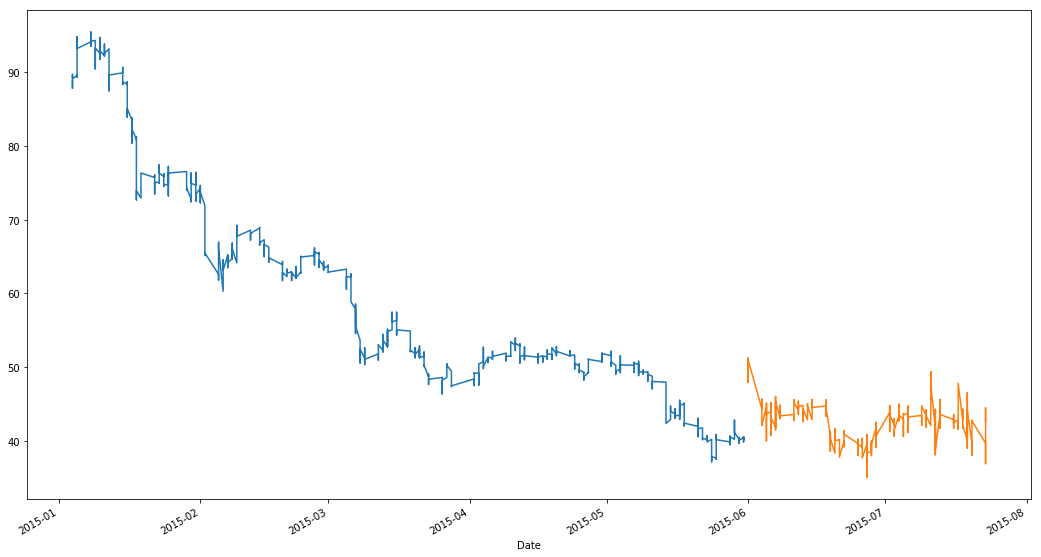

In [14]:
dft=train1.copy()
dft_=dft[dft['Symbol']=='und_2']
dft_['Date']=pd.to_datetime(dft_['Date'],format='%d-%m-%Y')
dft_.set_index('Date',inplace=True)
plt.figure(figsize=(18,10))
dft_['MidPrice'].plot()

n_=n[n['Symbol']=='und_2']
n_['Date']=pd.to_datetime(n_['Date'],format='%d-%m-%Y')
n_.set_index('Date',inplace=True)
n_['MidPrice'].plot()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


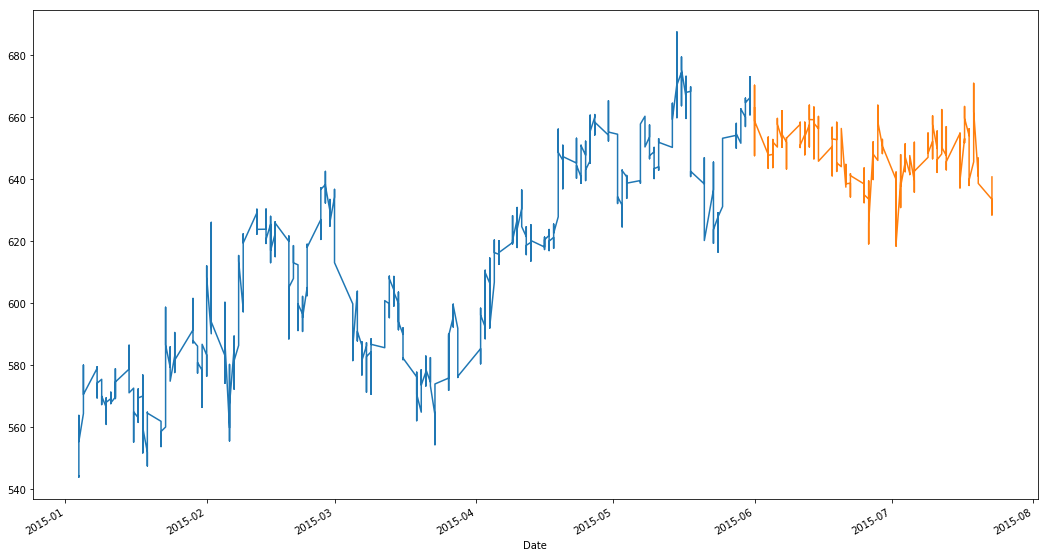

In [15]:
dft=train1.copy()
dft_=dft[dft['Symbol']=='und_137']
dft_['Date']=pd.to_datetime(dft_['Date'],format='%d-%m-%Y')
dft_.set_index('Date',inplace=True)
plt.figure(figsize=(18,10))
dft_['MidPrice'].plot()

n_=n[n['Symbol']=='und_137']
n_['Date']=pd.to_datetime(n_['Date'],format='%d-%m-%Y')
n_.set_index('Date',inplace=True)
n_['MidPrice'].plot()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


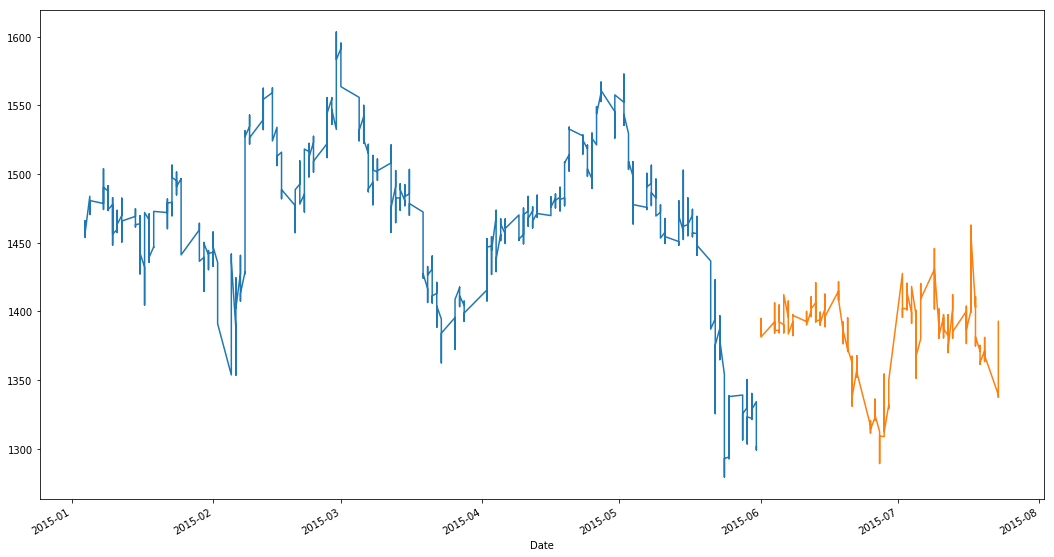

In [16]:
dft=train1.copy()
dft_=dft[dft['Symbol']=='und_60']
dft_['Date']=pd.to_datetime(dft_['Date'],format='%d-%m-%Y')
dft_.set_index('Date',inplace=True)
plt.figure(figsize=(18,10))
dft_['MidPrice'].plot()

n_=n[n['Symbol']=='und_60']
n_['Date']=pd.to_datetime(n_['Date'],format='%d-%m-%Y')
n_.set_index('Date',inplace=True)
n_['MidPrice'].plot()

In [17]:
n[(n['Symbol']=='und_1') &(n['Date']=='05-06-2015')]


,UID,BuySell,MidPrice,Date,Time,Symbol
264169,05-06-2015 09:30 und_1,0,2730.046330,05-06-2015,09:30,und_1
264170,05-06-2015 09:35 und_1,0,2732.867732,05-06-2015,09:35,und_1
264171,05-06-2015 09:40 und_1,1,2724.046722,05-06-2015,09:40,und_1
264172,05-06-2015 09:45 und_1,1,2734.039238,05-06-2015,09:45,und_1
264173,05-06-2015 09:50 und_1,1,2729.209537,05-06-2015,09:50,und_1
264174,05-06-2015 09:55 und_1,1,2725.909331,05-06-2015,09:55,und_1
264175,05-06-2015 10:00 und_1,0,2736.883488,05-06-2015,10:00,und_1
264176,05-06-2015 10:05 und_1,0,2733.318996,05-06-2015,10:05,und_1
264177,05-06-2015 10:10 und_1,0,2733.653704,05-06-2015,10:10,und_1
264178,05-06-2015 10:15 und_1,1,2722.183049,05-06-2015,10:15,und_1


In [18]:
calculate_stock_scores(n[(n['Symbol']=='und_1')])

position 1 ENtry pointset:  True ENP : 2940.5102942213275 EXP : 2917.3470672215713
position 1 ENtry pointset:  True ENP : 2932.2456977014026 EXP : 2913.460653727525
position 1 ENtry pointset:  True ENP : 2920.733753146769 EXP : 2890.543803809553
position 1 ENtry pointset:  True ENP : 2889.7282352889288 EXP : 2841.013004898728
position 1 ENtry pointset:  True ENP : 2864.402504196717 EXP : 2841.2735037270704
position 1 ENtry pointset:  True ENP : 2844.727800998621 EXP : 2822.4214025811702
position -1 ENtry pointset:  True ENP : 2828.1416422884777 EXP : 2833.363042181565
position 1 ENtry pointset:  True ENP : 2808.973935612145 EXP : 2799.223829248064
position 1 ENtry pointset:  True ENP : 2828.640872908476 EXP : 2811.05167890936
position 1 ENtry pointset:  True ENP : 2751.37879373699 EXP : 2734.226526062448
position 1 ENtry pointset:  True ENP : 2739.4999800345713 EXP : 2736.824189055211
position 1 ENtry pointset:  True ENP : 2735.80849125288 EXP : 2731.9660294251034
position -1 ENtry poi

0.0

# Submission

In [19]:
n.drop(['MidPrice','Date','Time','Symbol'],axis=1).to_csv('EW_mainsimplesub_v15.csv',index=False)